In [5]:
import torch

# 定义文件路径
file_path = "/root/cjiang/info_flow/Context-Cite/input_level_decompose/subspace_decompose/results/llama_3_1_8b_instruct_counterfact_results.pt"

# 加载数据
data_all = torch.load(file_path)

/tmp/ipykernel_19267/3989197402.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_all = torch.load(file_path)


In [7]:
data_all[4].keys()

dict_keys(['case_id', 'original', 'French', 'German', 'Italian', 'Portuguese', 'Spanish'])

In [8]:
data_all[4]['French'].keys()

dict_keys(['prompt', 'answer', 'predictions', 'lang_embedding', 'semantic_embedding'])

In [9]:
import torch
import numpy as np

# 初始化存储不同语言的embedding的字典
lang_embeddings = {
    'French': [],
    'German': [],
    'Italian': [],
    'Portuguese': [],
    'Spanish': [],
    'original': []
}

# 遍历所有数据，收集每种语言的embeddings
for data in data_all:
    for lang in lang_embeddings.keys():
        if lang in data and 'lang_embedding' in data[lang]:
            # 如果是tensor则转换为numpy
            if isinstance(data[lang]['lang_embedding'], torch.Tensor):
                embedding = data[lang]['lang_embedding'].numpy()
            else:
                embedding = data[lang]['lang_embedding']
            lang_embeddings[lang].append(embedding)

# 将列表转换为numpy数组
for lang in lang_embeddings:
    lang_embeddings[lang] = np.stack(lang_embeddings[lang])

# 打印每种语言的embedding形状
for lang, embeddings in lang_embeddings.items():
    print(f"{lang} embeddings shape: {embeddings.shape}")

French embeddings shape: (820, 4096)
German embeddings shape: (820, 4096)
Italian embeddings shape: (820, 4096)
Portuguese embeddings shape: (820, 4096)
Spanish embeddings shape: (820, 4096)
original embeddings shape: (820, 4096)


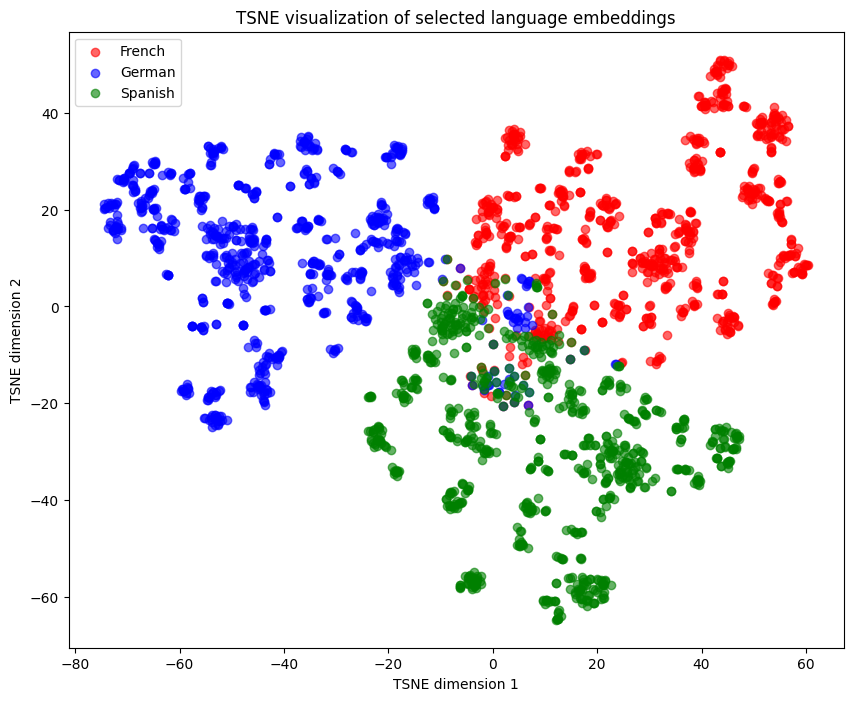

Clustering Evaluation Metrics:
Silhouette Score: 0.414
Davies-Bouldin Score: 0.870
Calinski-Harabasz Score: 2450.238


In [20]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def plot_tsne_with_metrics(lang_embeddings, selected_languages=None):
    """
    对选定语言的embeddings进行TSNE可视化并计算聚类评估指标
    Args:
        lang_embeddings: 包含所有语言embeddings的字典
        selected_languages: 要可视化的语言列表，如果为None则使用所有语言
    Returns:
        dict: 包含各项评估指标的字典
    """
    if selected_languages is None:
        selected_languages = list(lang_embeddings.keys())
    
    for lang in selected_languages:
        if lang not in lang_embeddings:
            raise ValueError(f"Language {lang} not found in embeddings")
    
    all_embeddings = []
    labels = []
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
    lang_to_color = dict(zip(selected_languages, colors[:len(selected_languages)]))
    
    # 准备数据和标签
    for lang in selected_languages:
        all_embeddings.append(lang_embeddings[lang])
        labels.extend([lang] * len(lang_embeddings[lang]))
    
    all_embeddings = np.vstack(all_embeddings)
    labels = np.array(labels)
    
    # 使用TSNE进行降维
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(all_embeddings)
    
    # 计算评估指标
    # 将字符串标签转换为数值标签
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    numeric_labels = le.fit_transform(labels)
    
    metrics = {
        'silhouette': silhouette_score(embeddings_2d, numeric_labels),
        'davies_bouldin': davies_bouldin_score(embeddings_2d, numeric_labels),
        'calinski_harabasz': calinski_harabasz_score(embeddings_2d, numeric_labels)
    }
    
    
    # 绘制散点图
    plt.figure(figsize=(10, 8))
    for lang in selected_languages:
        mask = labels == lang
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=lang_to_color[lang],
            label=lang,
            alpha=0.6
        )
    
    plt.legend()
    plt.title('TSNE visualization of selected language embeddings')
    plt.xlabel('TSNE dimension 1')
    plt.ylabel('TSNE dimension 2')
    plt.show()
    
    # 打印评估指标
    print("Clustering Evaluation Metrics:")
    print(f"Silhouette Score: {metrics['silhouette']:.3f}")
    print(f"Davies-Bouldin Score: {metrics['davies_bouldin']:.3f}")
    print(f"Calinski-Harabasz Score: {metrics['calinski_harabasz']:.3f}")
    
    return metrics

# 使用示例：
selected_langs = ['French', 'German', 'Spanish']
metrics = plot_tsne_with_metrics(lang_embeddings, selected_langs)

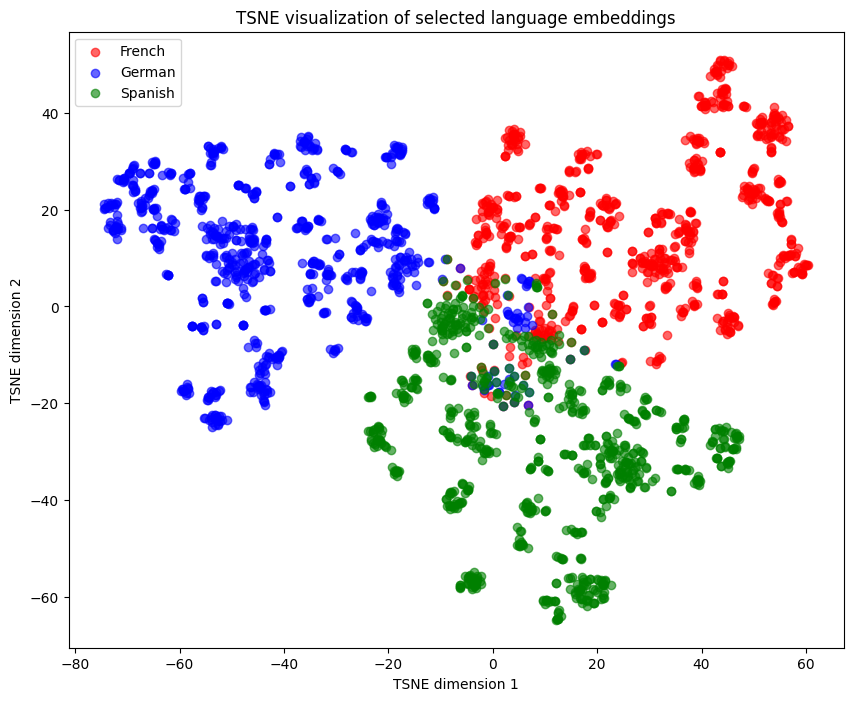

In [18]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(lang_embeddings, selected_languages=None):
    """
    对选定语言的embeddings进行TSNE可视化
    Args:
        lang_embeddings: 包含所有语言embeddings的字典
        selected_languages: 要可视化的语言列表，如果为None则使用所有语言
    """
    # 如果没有指定语言，使用所有语言
    if selected_languages is None:
        selected_languages = list(lang_embeddings.keys())
    
    # 检查选择的语言是否有效
    for lang in selected_languages:
        if lang not in lang_embeddings:
            raise ValueError(f"Language {lang} not found in embeddings")
    
    # 准备数据
    all_embeddings = []
    labels = []
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
    lang_to_color = dict(zip(selected_languages, colors[:len(selected_languages)]))
    
    # 只处理选定的语言
    for lang in selected_languages:
        all_embeddings.append(lang_embeddings[lang])
        labels.extend([lang] * len(lang_embeddings[lang]))
    
    # 将所有embeddings拼接成一个大矩阵
    all_embeddings = np.vstack(all_embeddings)
    
    # 使用TSNE进行降维
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(all_embeddings)
    
    # 绘制散点图
    plt.figure(figsize=(10, 8))
    for lang in selected_languages:
        mask = np.array(labels) == lang
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=lang_to_color[lang],
            label=lang,
            alpha=0.6
        )
    
    plt.legend()
    plt.title('TSNE visualization of selected language embeddings')
    plt.xlabel('TSNE dimension 1')
    plt.ylabel('TSNE dimension 2')
    plt.show()

# 使用示例：
# 选择特定语言进行可视化
selected_langs = ['French', 'German', 'Spanish']  # 可以根据需要选择语言
plot_tsne(lang_embeddings, selected_langs)

# 或者可视化所有语言
# plot_tsne(lang_embeddings)